In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('dirty_cafe_sales.csv')  
df.head()


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [3]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Handle missing values
# Initial Data Cleaning
# Replace 'ERROR' in 'Total Spent' with np.nan
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')

# Replace 'UNKNOWN' values with np.nan
df.replace('UNKNOWN', np.nan, inplace=True)

# Convert 'Transaction Date' to datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

# Fix column names if needed
# df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Display missing values
df.isnull().sum()

Transaction ID         0
Item                 677
Quantity             309
Price Per Unit       343
Total Spent          502
Payment Method      2872
Location            3603
Transaction Date     460
dtype: int64

In [4]:
# 🧼 Initial Data Cleaning
# Replace 'ERROR' in 'Total Spent' with np.nan
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')

# Replace 'UNKNOWN' values with np.nan
df.replace('UNKNOWN', np.nan, inplace=True)

# Convert 'Transaction Date' to datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

# Display missing values
df.isnull().sum()

Transaction ID         0
Item                 677
Quantity             309
Price Per Unit       343
Total Spent          502
Payment Method      2872
Location            3603
Transaction Date     460
dtype: int64

In [5]:
# 🧠 Fill missing values (Simple strategy)
df['Payment Method'].fillna(df['Payment Method'].mode()[0], inplace=True)
df['Location'].fillna(df['Location'].mode()[0], inplace=True)

# Fill or recalculate Total Spent where possible
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')

df['Total Spent'].fillna(df['Quantity'] * df['Price Per Unit'], inplace=True)

# Drop any remaining rows with missing values
df.dropna(inplace=True)

# Final check
df.isnull().sum()

Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64

In [6]:
# Convert datetime if applicable
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])  # Update column name as needed
df['year'] = df['Transaction Date'].dt.year
df['month'] = df['Transaction Date'].dt.month
df['day'] = df['Transaction Date'].dt.day
df['dayofweek'] = df['Transaction Date'].dt.dayofweek
df['hour'] = df['Transaction Date'].dt.hour

In [7]:
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [8]:
payment_encoder = LabelEncoder()
location_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['Payment Method'] = payment_encoder.fit_transform(df['Payment Method'])
df['Location'] = location_encoder.fit_transform(df['Location'])

# Encode target
df['Item'] = item_encoder.fit_transform(df['Item'])

In [9]:
# Save class mapping 
print("Item label classes:", item_encoder.classes_)

Item label classes: [0 1 2 3 4 5 6 7 8]


In [10]:
X = df[['Quantity', 'Price Per Unit', 'Payment Method', 'Location']]
y = df['Item']

In [11]:
# Train-test Split (optional for validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [13]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [14]:
# Save Model & Encoders
joblib.dump(model, "final_rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(payment_encoder, "payment_encoder.pkl")
joblib.dump(location_encoder, "location_encoder.pkl")
joblib.dump(item_encoder, "item_label_encoder.pkl")

print("✅ All assets saved successfully!")

✅ All assets saved successfully!


In [9]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


Accuracy: 0.7191780821917808
              precision    recall  f1-score   support

           0       0.47      0.58      0.52       206
           1       0.98      1.00      0.99       189
           2       0.96      1.00      0.98       180
           3       0.00      0.00      0.00        40
           4       0.51      0.42      0.46       220
           5       0.98      1.00      0.99       212
           6       0.45      0.68      0.54       177
           7       0.53      0.31      0.39       207
           8       0.98      1.00      0.99       175

    accuracy                           0.72      1606
   macro avg       0.65      0.67      0.65      1606
weighted avg       0.71      0.72      0.71      1606



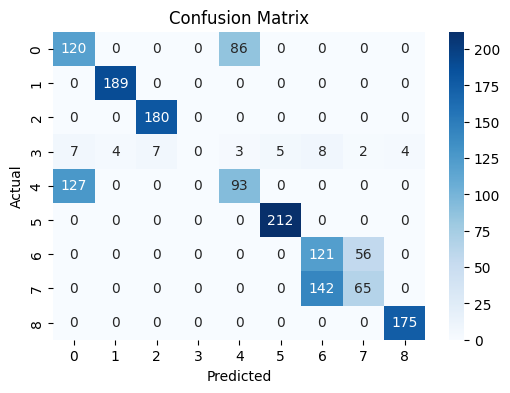

In [10]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


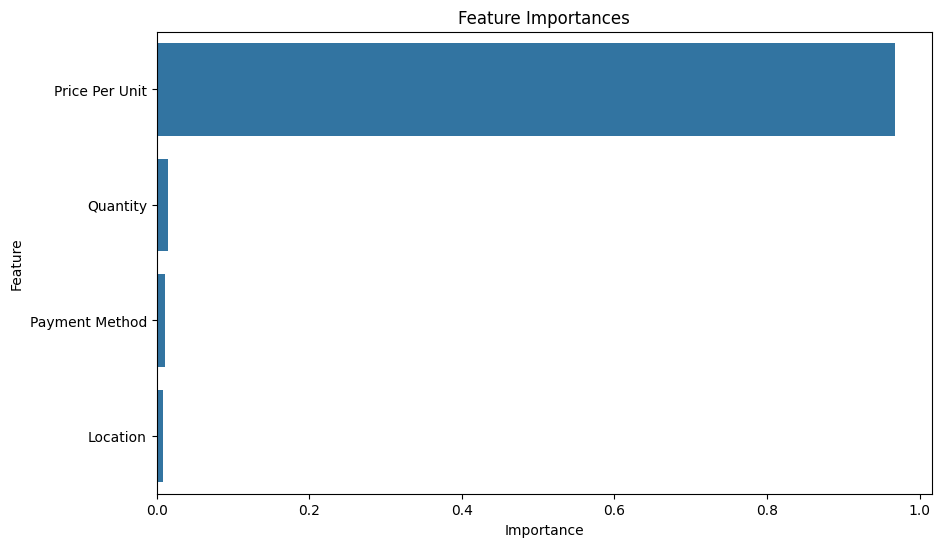

In [11]:
importances = best_model.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title("Feature Importances")
plt.show()


In [ ]:
# joblib.dump(best_model, 'final_rf_model.pkl')
# print("Model saved as 'final_rf_model.pkl'")


Model saved as 'final_rf_model.pkl'


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib


item_encoder = LabelEncoder()
y_encoded = item_encoder.fit_transform(df['Item'])  

# Save it AFTER fitting
joblib.dump(item_encoder, 'item_label_encoder.pkl')


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>)

In [ ]:
# Save scaler
joblib.dump(scaler, 'scaler.pkl')

# # Save item label encoder
# joblib.dump(label_encoder, 'item_label_encoder.pkl')


['item_label_encoder.pkl']

In [15]:
from sklearn.preprocessing import LabelEncoder
import joblib

# 1. Encode 'Payment Method'
payment_encoder = LabelEncoder()
df['Payment Method'] = payment_encoder.fit_transform(df['Payment Method'])

# 2. Encode 'Location'
location_encoder = LabelEncoder()
df['Location'] = location_encoder.fit_transform(df['Location'])

# 3. Save the encoders
joblib.dump(payment_encoder, 'payment_encoder.pkl')
joblib.dump(location_encoder, 'location_encoder.pkl')


['location_encoder.pkl']